# Ray RLlib - Introduction to Reinforcement Learning

© 2019-2020, Anyscale. All Rights Reserved

![Anyscale Academy](../images/AnyscaleAcademyLogo.png)

_Reinforcement Learning_ is the category of machine learning that focuses on training one or more _agents_ to achieve maximal _rewards_ while operating in an environment. This lesson discusses the core concepts of RL, while subsequent lessons explore RLlib in depth. We'll use two examples with exercises to give you a taste of RL. If you already understand RL concepts, you can either skim this lesson or skip to the [next lesson](02-Introduction-to-RLlib.ipynb).

## What Is Reinforcement Learning?

Let's explore the basic concepts of RL, specifically the _Markov Decision Process_ abstraction, and to show its use in Python.

Consider the following image:

![RL Concepts](../images/rllib/RL-concepts.png)

In RL, one or more **agents** interact with an **environment** to maximize a **reward**. The agents make **observations** about the **state** of the environment and take **actions** that are believed will maximize the long-term reward. However, at any particular moment, the agents can only observe the immediate reward. So, the training process usually involves lots and lot of replay of the game, the robot simulator traversing a virtual space, etc., so the agents can learn from repeated trials what decisions/actions work best to maximize the long-term, cumulative reward.

The trail and error search and delayed reward are the distinguishing characterists of RL vs. other ML methods ([Sutton 2018](06-RL-References.ipynb#Books)).

The way to formalize trial and error is the **exploitation vs. exploration tradeoff**. When an agent finds what appears to be a "rewarding" sequence of actions, the agent may naturally want to continue to **exploit** these actions. However, even better actions may exist. An agent won't know whether alternatives are better or not unless some percentage of actions taken **explore** the alternatives. So, all RL algorithms include a strategy for exploitation and exploration.

## RL Applications

RL has many potential applications. RL became "famous" due to these successes, including achieving expert game play, training robots, autonomous vehicles, and other simulated agents:

![AlphaGo](../images/rllib/alpha-go.jpg)
![Game](../images/rllib/breakout.png)

![Stacking Legos with Sawyer](../images/rllib/stacking-legos-with-sawyer.gif)
![Walking Man](../images/rllib/walking-man.gif)

![Autonomous Vehicle](../images/rllib/daimler-autonomous-car.jpg)
!["Cassie": Two-legged Robot](../images/rllib/cassie-crouched.png)

Credits:
* [AlphaGo](https://www.youtube.com/watch?v=l7ngy56GY6k)
* [Breakout](https://towardsdatascience.com/tutorial-double-deep-q-learning-with-dueling-network-architectures-4c1b3fb7f756) ([paper](https://arxiv.org/abs/1312.5602))
* [Stacking Legos with Sawyer](https://robohub.org/soft-actor-critic-deep-reinforcement-learning-with-real-world-robots/)
* [Walking Man](https://openai.com/blog/openai-baselines-ppo/)
* [Autonomous Vehicle](https://www.daimler.com/innovation/case/autonomous/intelligent-drive-2.html)
* ["Cassie": Two-legged Robot](https://mime.oregonstate.edu/research/drl/robots/cassie/) (Uses Ray!)

Recently other industry applications have emerged, include the following:

* **Process optimization:** industrial processes (factories, pipelines) and other business processes, routing problems, cluster optimization.
* **Ad serving and recommendations:** Some of the traditional methods, including _collaborative filtering_, are hard to scale for very large data sets. RL systems are being developed to do an effective job more efficiently than traditional methods.
* **Finance:** Markets are time-oriented _environments_ where automated trading systems are the _agents_. 

## Markov Decision Processes

At its core, Reinforcement learning builds on the concepts of [Markov Decision Process (MDP)](https://en.wikipedia.org/wiki/Markov_decision_process), where the current state, the possible actions that can be taken, and overall goal are the building blocks.

An MDP models sequential interactions with an external environment. It consists of the following:

- a **state space** where the current state of the system is sometimes called the **context**.
- a set of **actions** that can be taken at a particular state $s$ (or sometimes the same set for all states).
- a **transition function** that describes the probability of being in a state $s'$ at time $t+1$ given that the MDP was in state $s$ at time $t$ and action $a$ was taken. The next state is selected stochastically based on these probabilities.
- a **reward function**, which determines the reward received at time $t$ following action $a$, based on the decision of **policy** $\pi$.

The goal of MDP is to develop a **policy** $\pi$ that specifies what action $a$ should be chosen for a given state $s$ so that the cumulative reward is maximized. When it is possible for the policy "trainer" to fully observe all the possible states, actions, and rewards, it can define a deterministic policy, fixing a single action choice for each state. In this scenario, the transition probabilities reduce to the probability of transitioning to state $s'$ given the current state is $s$, independent of actions, because the state now leads to a deterministic action choice. Various algorithms can be used to compute this policy. 

Put another way, if the policy isn't deterministic, then the transition probability to state $s'$ at a time $t+1$ when action $a$ is taken for state $s$ at time $t$, is given by:

\begin{equation}
P_a(s',s) = P(s_{t+1} = s'|s_t=s,a)
\end{equation}

When the policy is deterministic, this transition probability reduces to the following, independent of $a$:

\begin{equation}
P(s',s) = P(s_{t+1} = s'|s_t=s)
\end{equation}

To be clear, a deterministic policy means that one and only one action will always be selected for a given state $s$, but the next state $s'$ will still be selected stochastically.

In the general case of RL, it isn't possible to fully know all this information, some of which might be hidden and evolving, so it isn't possible to specify a fully-deterministic policy.

Often this cumulative reward is computed using the **discounted sum** over all rewards observed:

\begin{equation}
\arg\max_{\pi} \sum_{t=1}^T \gamma^t R_t(\pi),
\end{equation}

where $T$ is the number of steps taken in the MDP (this is a random variable and may depend on $\pi$), $R_t$ is the reward received at time $t$ (also a random variable which depends on $\pi$), and $\gamma$ is the **discount factor**. The value of $\gamma$ is between 0 and 1, meaning it has the effect of "discounting" earlier rewards vs. more recent rewards. 

The [Wikipedia page on MDP](https://en.wikipedia.org/wiki/Markov_decision_process) provides more details. Note what we said in the third bullet, that the new state only depends on the previous state and the action taken. The assumption is that we can simplify our effort by ignoring all the previous states except the last one and still achieve good results. This is known as the [Markov property](https://en.wikipedia.org/wiki/Markov_property). This assumption often works well and it greatly reduces the resources required.

## The Elements of RL

Here are the elements of RL that expand on MDP concepts (see [Sutton 2018](https://mitpress.mit.edu/books/reinforcement-learning-second-edition) for more details):

#### Policies

Unlike MDP, the **transition function** probabilities are often not known in advance, but must be learned. Learning is done through repeated "play", where the agent interacts with the environment.

This makes the **policy** $\pi$ harder to determine. Because the fully state space usually can't be fully known, the choice of action $a$ for given state $s$ almostly always remains a stochastic choice, never deterministic, unlike MDP.

#### Reward Signal

The idea of a **reward signal** encapsulates the desired goal for the system and provides feedback for updating the policy based on how well particular events or actions contribute rewards towards the goal.

#### Value Function

The **value function** encapsulates the maximum cumulative reward likely to be achieved starting from a given state for an **episode**. This is harder to determine than the simple reward returned after taking an action. In fact, much of the research in RL over the decades has focused on finding better and more efficient implementations of value functions. To illustrate the challenge, repeatedly taking one sequence of actions may yield low rewards for a while, but eventually provide large rewards. Conversely, always choosing a different sequence of actions may yield a good reward at each step, but be suboptimal for the cumulative reward.

#### Episode

A sequence of steps by the agent starting in an initial state. At each step, the agent observes the current state, chooses the next action, and receives the new reward. Episodes are used for both training policies and replaying with an existing policy (called _rollout_).

#### Model

An optional feature, some RL algorithms develop or use a **model** of the environment to anticipate the resulting states and rewards for future actions. Hence, they are useful for _planning_ scenarios. Methods for solving RL problems that use models are called _model-based methods_, while methods that learn by trial and error are called _model-free methods_.

## Reinforcement Learning Example

Let's finish this introduction let's learn about the popular "hello world" (1) example environment for RL, balancing a pole vertically on a moving cart, called `CartPole`. Then we'll see how to use RLlib to train a policy using a popular RL algorithm, _Proximal Policy Optimization_, again using `CartPole`.

(1) In books and tutorials on programming languages, it is a tradition that the very first program shown prints the message "Hello World!".

### CartPole and OpenAI

The popular [OpenAI "gym" environment](https://gym.openai.com/) provides MDP interfaces to a variety of simulated environments. Perhaps the most popular for learning RL is `CartPole`, a simple environment that simulates the physics of balancing a pole on a moving cart. The `CartPole` problem is described at https://gym.openai.com/envs/CartPole-v1. Here is an image from that website, where the pole is currently falling to the right, which means the cart will need to move to the right to restore balance:

![Cart Pole](../images/rllib/Cart-Pole.png)

This example fits into the MDP framework as follows:
- The **state** consists of the position and velocity of the cart (moving in one dimension from left to right) as well as the angle and angular velocity of the pole that is balancing on the cart.
- The **actions** are to decrease or increase the cart's velocity by one unit. A negative velocity means it is moving to the left.
- The **transition function** is deterministic and is determined by simulating physical laws. Specifically, for a given **state**, what should we choose as the next velocity value? In the RL context, the correct velocity value to choose has to be learned. Hence, we learn a _policy_ that approximates the optimal transition function that could be calculated from the laws of physics.
- The **reward function** is a constant 1 as long as the pole is upright, and 0 once the pole has fallen over. Therefore, maximizing the reward means balancing the pole for as long as possible.
- The **discount factor** in this case can be taken to be 1, meaning we treat the rewards at all time steps equally and don't discount any of them.

More information about the `gym` Python module is available at https://gym.openai.com/. The list of all the available Gym environments is in [this wiki page](https://github.com/openai/gym/wiki/Table-of-environments). We'll use a few more of them and even create our own in subsequent lessons.

In [1]:
import gym
import numpy as np
import pandas as pd
import json

The code below illustrates how to create and manipulate MDPs in Python. An MDP can be created by calling `gym.make`. Gym environments are identified by names like `CartPole-v1`. A **catalog of built-in environments** can be found at https://gym.openai.com/envs.

In [2]:
env = gym.make("CartPole-v1")
print("Created env:", env)

Created env: <TimeLimit<CartPoleEnv<CartPole-v1>>>


Reset the state of the MDP by calling `env.reset()`. This call returns the initial state of the MDP.

In [3]:
state = env.reset()
print("The starting state is:", state)

The starting state is: [0.01134889 0.00129055 0.02062973 0.03990571]


Recall that the state is the position of the cart, its velocity, the angle of the pole, and the angular velocity of the pole.

The `env.step` method takes an action. In the case of the `CartPole` environment, the appropriate actions are 0 or 1, for pushing the cart to the left or right, respectively. `env.step()` returns a tuple of four things:
1. the new state of the environment
2. a reward
3. a boolean indicating whether the simulation has finished
4. a dictionary of miscellaneous extra information

Let's show what happens if we take one step with an action of 0.

In [4]:
action = 0
state, reward, done, info = env.step(action)
print(state, reward, done, info)

[ 0.01137471 -0.19412106  0.02142784  0.33902547] 1.0 False {}


A **rollout** is a simulation of a policy in an environment. It is used both during training and when running simulations with a trained policy. 

The code below performs a rollout in a given environment. It takes **random actions** until the simulation has finished and returns the cumulative reward.

In [5]:
def random_rollout(env):
    state = env.reset()
    
    done = False
    cumulative_reward = 0

    # Keep looping as long as the simulation has not finished.
    while not done:
        # Choose a random action (either 0 or 1).
        action = np.random.choice([0, 1])
        
        # Take the action in the environment.
        state, reward, done, _ = env.step(action)
        
        # Update the cumulative reward.
        cumulative_reward += reward
    
    # Return the cumulative reward.
    return cumulative_reward    

Try rerunning the following cell a few times. How much do the answers change? Note that the maximum possible reward for `CartPole-v1` is 500. You'll probably get numbers well under 500.

In [6]:
reward = random_rollout(env)
print(reward)

reward = random_rollout(env)
print(reward)

21.0
13.0


### Exercise 1

Choosing actions at random in `random_rollout` is not a very effective policy, as the previous results showed. Finish implementing the `rollout_policy` function below, which takes an environment *and* a policy. Recall that the *policy* is a function that takes in a *state* and returns an *action*. The main difference is that instead of choosing a **random action**, like we just did (with poor results), the action should be chosen **with the policy** (as a function of the state).

> **Note:** Exercise solutions for this tutorial can be found [here](solutions/Ray-RLlib-Solutions.ipynb).

In [7]:
def rollout_policy(env, policy):
    state = env.reset()
    
    done = False
    cumulative_reward = 0

    # EXERCISE: Fill out this function by copying the appropriate part of 'random_rollout'
    # and modifying it to choose the action using the policy.
    #raise NotImplementedError
    # Keep looping as long as the simulation has not finished.
    while not done:
        # Choose a random action (either 0 or 1).
        action = policy(state)
        
        # Take the action in the environment.
        state, reward, done, _ = env.step(action)
        
        # Update the cumulative reward.
        cumulative_reward += reward
        
    # Return the cumulative reward.
    return cumulative_reward

def sample_policy1(state):
    return 0 if state[0] < 0 else 1

def sample_policy2(state):
    return 1 if state[0] < 0 else 0

reward1 = np.mean([rollout_policy(env, sample_policy1) for _ in range(100)])
reward2 = np.mean([rollout_policy(env, sample_policy2) for _ in range(100)])

print('The first sample policy got an average reward of {}.'.format(reward1))
print('The second sample policy got an average reward of {}.'.format(reward2))

assert 5 < reward1 < 15, ('Make sure that rollout_policy computes the action '
                          'by applying the policy to the state.')
assert 25 < reward2 < 35, ('Make sure that rollout_policy computes the action '
                           'by applying the policy to the state.')

The first sample policy got an average reward of 9.39.
The second sample policy got an average reward of 27.66.


We'll return to `CartPole` in lesson [01: Application Cart Pole](explore-rllib/01-Application-Cart-Pole.ipynb) in the `explore-rllib` section.

### RLlib Reinforcement Learning Example: Cart Pole with Proximal Policy Optimization

This section demonstrates how to use the _proximal policy optimization_ (PPO) algorithm implemented by [RLlib](http://rllib.io). PPO is a popular way to develop a policy. RLlib also uses [Ray Tune](http://tune.io), the Ray Hyperparameter Tuning framework, which is covered in the [Ray Tune Tutorial](../ray-tune/00-Ray-Tune-Overview.ipynb).

We'll provide relatively little explanation of **RLlib** concepts for now, but explore them in greater depth in subsequent lessons. For more on RLlib, see the documentation at http://rllib.io.

PPO is described in detail in [this paper](https://arxiv.org/abs/1707.06347). It is a variant of _Trust Region Policy Optimization_ (TRPO) described in [this earlier paper](https://arxiv.org/abs/1502.05477). [This OpenAI post](https://openai.com/blog/openai-baselines-ppo/) provides a more accessible introduction to PPO.

PPO works in two phases. In the first phase, a large number of rollouts are performed in parallel. The rollouts are then aggregated on the driver and a surrogate optimization objective is defined based on those rollouts. In the second phase, we use SGD (_stochastic gradient descent_) to find the policy that maximizes that objective with a penalty term for diverging too much from the current policy.

![PPO](../images/rllib/ppo.png)

> **NOTE:** The SGD optimization step is best performed in a data-parallel manner over multiple GPUs. This is exposed through the `num_gpus` field of the `config` dictionary. Hence, for normal usage, one or more GPUs is recommended.

(The original version of this example can be found [here](https://raw.githubusercontent.com/ucbrise/risecamp/risecamp2018/ray/tutorial/rllib_exercises/)).

In [10]:
import ray
from ray.rllib.agents.ppo import PPOTrainer, DEFAULT_CONFIG
from ray.tune.logger import pretty_print

Initialize Ray. If you are running these tutorials on your laptop, then a single-node Ray cluster will be started by the next cell. If you are running in the Anyscale platform, it will connect to the running Ray cluster.

In [11]:
info = ray.init(ignore_reinit_error=True, log_to_driver=False)

2021-01-03 15:19:47,083	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


> **Tip:** Having trouble starting Ray? See the [Troubleshooting](../reference/Troubleshooting-Tips-Tricks.ipynb) tips.

The next cell prints the URL for the Ray Dashboard. **This is only correct if you are running this tutorial on a laptop.** Click the link to open the dashboard.

If you are running on the Anyscale platform, use the URL provided by your instructor to open the Dashboard.

In [12]:
print("Dashboard URL: http://{}".format(info["webui_url"]))

Dashboard URL: http://127.0.0.1:8265


Instantiate a PPOTrainer object. We pass in a config object that specifies how the network and training procedure should be configured. Some of the parameters are the following.

- `num_workers` is the number of actors that the agent will create. This determines the degree of parallelism that will be used. In a cluster, these actors will be spread over the available nodes.
- `num_sgd_iter` is the number of epochs of SGD (stochastic gradient descent, i.e., passes through the data) that will be used to optimize the PPO surrogate objective at each iteration of PPO, for each _minibatch_ ("chunk") of training data. Using minibatches is more efficient than training with one record at a time.
- `sgd_minibatch_size` is the SGD minibatch size (batches of data) that will be used to optimize the PPO surrogate objective.
- `model` contains a dictionary of parameters describing the neural net used to parameterize the policy. The `fcnet_hiddens` parameter is a list of the sizes of the hidden layers. Here, we have two hidden layers of size 100, each.
- `num_cpus_per_worker` when set to 0 prevents Ray from pinning a CPU core to each worker, which means we could run out of workers in a constrained environment like a laptop or a cloud VM.

In [13]:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 1
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 128
config['model']['fcnet_hiddens'] = [100, 100]
config['num_cpus_per_worker'] = 0 

In [15]:
print(config)

{'num_workers': 1, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 200, 'batch_mode': 'truncate_episodes', 'num_gpus': 0, 'train_batch_size': 4000, 'model': {'fcnet_hiddens': [100, 100], 'fcnet_activation': 'tanh', 'conv_filters': None, 'conv_activation': 'relu', 'free_log_std': False, 'no_final_linear': False, 'vf_share_layers': True, 'use_lstm': False, 'max_seq_len': 20, 'lstm_cell_size': 256, 'lstm_use_prev_action': False, 'lstm_use_prev_reward': False, '_time_major': False, 'framestack': True, 'dim': 84, 'grayscale': False, 'zero_mean': True, 'custom_model': None, 'custom_model_config': {}, 'custom_action_dist': None, 'custom_preprocessor': None, 'lstm_use_prev_action_reward': -1}, 'optimizer': {}, 'gamma': 0.99, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env_config': {}, 'env': None, 'normalize_actions': False, 'clip_rewards': None, 'clip_actions': True, 'preprocessor_pref': 'deepmind', 'lr': 5e-05, 'monitor': False, 'log_

In [14]:
agent = PPOTrainer(config, 'CartPole-v1')

2021-01-03 15:29:00,074	INFO trainer.py:591 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
2021-01-03 15:29:00,075	INFO trainer.py:616 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2021-01-03 15:29:05,093	WARNING util.py:43 -- Install gputil for GPU system monitoring.


Now let's train the policy on the `CartPole-v1` environment for `N` steps. The JSON object returned by each call to `agent.train()` contains a lot of information we'll inspect below. For now, we'll extract information we'll graph, such as `episode_reward_mean`. The _mean_ values are more useful for determining successful training.

In [18]:
N = 10
results = []
episode_data = []
episode_json = []

for n in range(N):
    result = agent.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_min':  result['episode_reward_min'],  
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max':  result['episode_reward_max'],  
               'episode_len_mean':    result['episode_len_mean']} 
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    
    print(f'{n:3d}: Min/Mean/Max reward: {result["episode_reward_min"]:8.4f}/{result["episode_reward_mean"]:8.4f}/{result["episode_reward_max"]:8.4f}')

Instructions for updating:
Prefer Variable.assign which has equivalent behavior in 2.X.
  0: Min/Mean/Max reward:   9.0000/ 22.1889/131.0000
  1: Min/Mean/Max reward:   9.0000/ 38.3462/138.0000
  2: Min/Mean/Max reward:   9.0000/ 55.7200/185.0000
  3: Min/Mean/Max reward:   9.0000/ 84.6200/284.0000
  4: Min/Mean/Max reward:  12.0000/116.7200/412.0000
  5: Min/Mean/Max reward:  13.0000/150.4700/435.0000
  6: Min/Mean/Max reward:  13.0000/180.5500/500.0000
  7: Min/Mean/Max reward:  13.0000/215.1000/500.0000
  8: Min/Mean/Max reward:  13.0000/249.4600/500.0000
  9: Min/Mean/Max reward:  13.0000/282.2500/500.0000


Now let's convert the episode data to a Pandas `DataFrame` for easy manipulation. The results indicate how much reward the policy is receiving (`episode_reward_*`) and how many time steps of the environment the policy ran (`episode_len_mean`). The maximum possible reward for this problem is `500`. The reward mean and trajectory length are very close because the agent receives a reward of one for every time step that it survives. However, this is specific to this environment and not true in general.

In [19]:
df = pd.DataFrame(data=episode_data)
df

,n,episode_reward_min,episode_reward_mean,episode_reward_max,episode_len_mean
0,0,9.0,22.188889,131.0,22.188889
1,1,9.0,38.346154,138.0,38.346154
2,2,9.0,55.720000,185.0,55.720000
3,3,9.0,84.620000,284.0,84.620000
4,4,12.0,116.720000,412.0,116.720000
5,5,13.0,150.470000,435.0,150.470000
6,6,13.0,180.550000,500.0,180.550000
7,7,13.0,215.100000,500.0,215.100000
8,8,13.0,249.460000,500.0,249.460000
9,9,13.0,282.250000,500.0,282.250000


In [20]:
df.columns.tolist()

['n',
 'episode_reward_min',
 'episode_reward_mean',
 'episode_reward_max',
 'episode_len_mean']

Let's plot the data. Since the length and reward means are equal, we'll only plot one line:

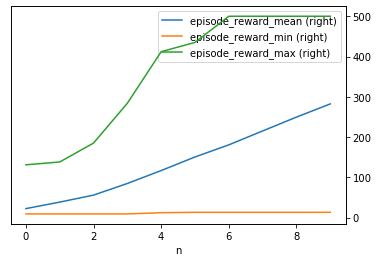

In [21]:
df.plot(x="n", y=["episode_reward_mean", "episode_reward_min", "episode_reward_max"], secondary_y=True)

The model is quickly able to hit the maximum value of 500, but the mean is what's most valuable. After 10 steps, we're more than half way there.

FYI, here are two views of the whole value for one result. First, a "pretty print" output.

> **Tip:** The output will be long. When this happens for a cell, right click and select _Enable scrolling for outputs_.

In [22]:
print(pretty_print(results[-1]))

custom_metrics: {}
date: 2021-01-03_15-34-09
done: false
episode_len_mean: 282.25
episode_reward_max: 500.0
episode_reward_mean: 282.25
episode_reward_min: 13.0
episodes_this_iter: 8
episodes_total: 439
experiment_id: b0412eb1379e4b178f8b4dc9100b610e
hostname: chengyu-desktop
info:
  learner:
    default_policy:
      cur_kl_coeff: 0.15000000596046448
      cur_lr: 4.999999873689376e-05
      entropy: 0.5122473239898682
      entropy_coeff: 0.0
      kl: 0.005576164461672306
      model: {}
      policy_loss: -0.005310930777341127
      total_loss: 678.9248657226562
      vf_explained_var: 9.750165918376297e-05
      vf_loss: 678.9293823242188
  num_steps_sampled: 40000
  num_steps_trained: 40000
iterations_since_restore: 10
node_ip: 192.168.87.36
num_healthy_workers: 1
off_policy_estimator: {}
perf:
  cpu_util_percent: 25.25
  ram_util_percent: 57.199999999999996
pid: 14252
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf:
  mean_action_processing_ms: 0.

We'll learn about more of these values as continue the tutorial.

The whole, long JSON blob, which includes the historical stats about episode rewards and lengths:

In [23]:
results[-1]

{'episode_reward_max': 500.0,
 'episode_reward_min': 13.0,
 'episode_reward_mean': 282.25,
 'episode_len_mean': 282.25,
 'episodes_this_iter': 8,
 'policy_reward_min': {},
 'policy_reward_max': {},
 'policy_reward_mean': {},
 'custom_metrics': {},
 'hist_stats': {'episode_reward': [500.0,
   500.0,
   500.0,
   500.0,
   500.0,
   500.0,
   500.0,
   500.0,
   13.0,
   110.0,
   27.0,
   48.0,
   43.0,
   103.0,
   262.0,
   201.0,
   224.0,
   124.0,
   158.0,
   201.0,
   76.0,
   104.0,
   174.0,
   284.0,
   115.0,
   123.0,
   75.0,
   20.0,
   197.0,
   214.0,
   257.0,
   193.0,
   138.0,
   135.0,
   99.0,
   282.0,
   189.0,
   233.0,
   243.0,
   169.0,
   173.0,
   168.0,
   149.0,
   139.0,
   301.0,
   200.0,
   224.0,
   306.0,
   143.0,
   125.0,
   270.0,
   412.0,
   215.0,
   350.0,
   91.0,
   292.0,
   326.0,
   201.0,
   375.0,
   435.0,
   283.0,
   400.0,
   307.0,
   383.0,
   234.0,
   252.0,
   410.0,
   284.0,
   147.0,
   170.0,
   500.0,
   237.0,
   500.0,

Let's plot the `episode_reward` values:

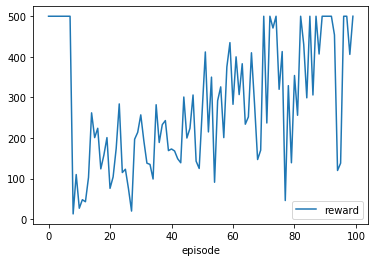

In [24]:
episode_rewards = results[-1]['hist_stats']['episode_reward']
df_episode_rewards = pd.DataFrame(data={'episode':range(len(episode_rewards)), 'reward':episode_rewards})

df_episode_rewards.plot(x="episode", y="reward")

For a well-trained model, most runs do very well while occasional runs do poorly. Try plotting other results episodes by changing the array index in `results[-1]` to another number between `0` and `9`. (The length of `results` is `10`.)

### Exercise 2

The current network and training configuration are too large and heavy-duty for a simple problem like `CartPole`. Modify the configuration to use a smaller network (the `config['model']['fcnet_hiddens']` setting) and to speed up the optimization of the surrogate objective. (Fewer SGD iterations and a larger batch size should help.)

In [25]:
# Make edits here:
config = DEFAULT_CONFIG.copy()
config['num_workers'] = 3
config['num_sgd_iter'] = 30
config['sgd_minibatch_size'] = 256
config['model']['fcnet_hiddens'] = [32, 16]
config['num_cpus_per_worker'] = 0

agent = PPOTrainer(config, 'CartPole-v1')

2021-01-03 15:43:35,502	WARNING util.py:43 -- Install gputil for GPU system monitoring.


Train the agent and try to get a reward of 500. If it's training too slowly you may need to modify the config above to use fewer hidden units, a larger `sgd_minibatch_size`, a smaller `num_sgd_iter`, or a larger `num_workers`.

This should take around `N` = 20 or 30 training iterations.

In [26]:
N = 5
results = []
episode_data = []
episode_json = []

for n in range(N):
    result = agent.train()
    results.append(result)
    
    episode = {'n': n, 
               'episode_reward_mean': result['episode_reward_mean'], 
               'episode_reward_max': result['episode_reward_max'],  
               'episode_len_mean': result['episode_len_mean']}   
    
    episode_data.append(episode)
    episode_json.append(json.dumps(episode))
    
    print(f'Max reward: {episode["episode_reward_max"]}')

Max reward: 95.0
Max reward: 90.0
Max reward: 104.0
Max reward: 218.0
Max reward: 262.0


# Using Checkpoints

You checkpoint the current state of a trainer to save what it has learned. Checkpoints are used for subsequent _rollouts_ and also to continue training later from a known-good state.  Calling `agent.save()` creates the checkpoint and returns the path to the checkpoint file, which can be used later to restore the current state to a new trainer. Here we'll load the trained policy into the same process, but often it would be loaded in a new process, for example on a production cluster for serving that is separate from the training cluster.

In [27]:
checkpoint_path = agent.save()
print(checkpoint_path)

/home/chengyu/ray_results/PPO_CartPole-v1_2021-01-03_15-43-30g363f_3a/checkpoint_5/checkpoint-5


Now load the checkpoint in a new trainer:

In [28]:
trained_config = config.copy()
test_agent = PPOTrainer(trained_config, "CartPole-v1")
test_agent.restore(checkpoint_path)

2021-01-03 15:46:32,705	WARNING util.py:43 -- Install gputil for GPU system monitoring.
2021-01-03 15:46:32,774	INFO trainable.py:328 -- Restored on 192.168.87.36 from checkpoint: /home/chengyu/ray_results/PPO_CartPole-v1_2021-01-03_15-43-30g363f_3a/checkpoint_5/checkpoint-5
2021-01-03 15:46:32,775	INFO trainable.py:336 -- Current state after restoring: {'_iteration': 5, '_timesteps_total': None, '_time_total': 9.170154571533203, '_episodes_total': 528}


Use the previously-trained policy to act in an environment. The key line is the call to `test_agent.compute_action(state)` which uses the trained policy to choose an action. This is an example of _rollout_, which we'll study in a subsequent lesson.

Verify that the cumulative reward received roughly matches up with the reward printed above. It will be at or near 500.

In [29]:
env = gym.make("CartPole-v1")
state = env.reset()
done = False
cumulative_reward = 0

while not done:
    action = test_agent.compute_action(state)  # key line; get the next action
    state, reward, done, _ = env.step(action)
    cumulative_reward += reward

print(cumulative_reward)

126.0


In [30]:
ray.shutdown()

The next lesson, [02: Introduction to RLlib](02-Introduction-to-RLlib.ipynb) steps back to introduce to RLlib, its goals and the capabilities it provides.